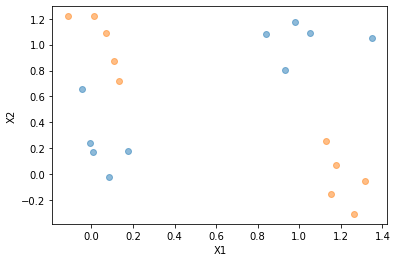

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
      dtype=int32)

In [22]:
import matplotlib.pyplot as plt
import numpy as np

from numpy import arange, meshgrid, hstack
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize

def geradataset(tamanho=20, centros=[[0,0],[1,0],[1,1],[0,1]]):
    X, y = make_blobs(n_samples=tamanho, centers=centros, cluster_std=0.2)
    y = np.array(y%2, dtype=int)
    return X, y

def plotadataset(X, y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.5)

def plotahiperplano(vetor, bias=0, xmin=0, xmax=1):
    xs = np.linspace(xmin, xmax, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - bias / vetor[1]
    plt.plot(xs,ys)

def gridregiaodecisao(X):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1

    # define the x and y scale
    x1grid = arange(min1, max1, 0.1)
    x2grid = arange(min2, max2, 0.1)

    # create all of the lines and rows of the grid
    xx, yy = meshgrid(x1grid, x2grid)

    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontal stack vectors to create x1,x2 input for the model
    grid = hstack((r1,r2))

    return xx, yy, grid

def plotregiaodecisao(xx, yy, yhat):
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)

    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')


X, y = geradataset()
plotadataset(X, y)
plt.show()
y

In [2]:
class CustoPerceptron():
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum(CustoPerceptron.erro(y, ypred)**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, CustoPerceptron.erro(y, ypred))

class Adaline():
    def __init__(self):
        self.preactivated = True
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - Adaline.erro(y, ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, Adaline.erro(y, ypred))

# Algoritmos

In [3]:
class DescidaGradiente():
    def __init__(self, custo=Adaline(), maxiter=1000, alpha=0.005):
        self.custo = custo
        self.maxiter = maxiter
        self.alpha = alpha
    
    def getW(self, X, y, activation=lambda a: a):
        w = np.random.uniform(-1, -1, size=(X.shape[1], y.shape[1]))
        for _ in range(self.maxiter):
            ypred = activation(np.matmul(X, w))
            custo = self.custo.custo(y, ypred)
            if custo == 0:
                break
            w = w + self.alpha * self.custo.gradiente(y, ypred, X)
        return w

class PseudoInversa():
    def __init__(self):
        pass
    def getW(self, X, y):
        pinv = np.linalg.pinv(X)
        w = np.matmul(pinv, y)
        return w

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit

def tanh(a):
    return expit(a) * 2 - 1

class ExtremeLearningMachine(BaseEstimator, ClassifierMixin):
    def __init__(self, algoritmo=PseudoInversa()):
        self.wih = None
        self.w = None
        self.threshold = 0
        self.activation = tanh
        self.algoritmo = algoritmo
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb
    
    def fit(self, X, y):
        self.wih = np.random.uniform(-1, 1, size=(X.shape[1],X.shape[0]//3))
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        X = ExtremeLearningMachine.includebias(Xho)
        self.labels = list(set(y))
        y = label_binarize(y, classes=self.labels)*2-1
        if len(self.labels) == 2 :
            y = y[:,0:1]
        # treinamento
        if hasattr(self.algoritmo, 'custo') and not (hasattr(self.algoritmo.custo, 'preactivated') and self.algoritmo.custo.preactivated):
            self.w = self.algoritmo.getW(X, y, self.activation)
        else:
            self.w = self.algoritmo.getW(X, y)

    def predict(self, X):
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        Xb = ExtremeLearningMachine.includebias(Xho)
        a = np.matmul(Xb, self.w)
        if self.w.shape[1] > 1:
            idx = np.argmax(a, axis=1) 
        else:
            idx = np.array(self.activation(a) > self.threshold, dtype=int)[:,0]
        ypred = np.array([self.labels[i] for i in idx])
        return ypred



In [9]:
elm = ExtremeLearningMachine()
elm.fit(X, y)
ypred = elm.predict(X)
print(sum(y == ypred)/len(y))
# Teste com amostras fora do treinamento
Xte, yte = geradataset(10000)
ypred = elm.predict(Xte)
print(sum(yte == ypred)/len(yte))

1.0
0.9618


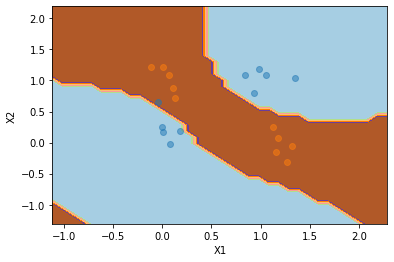

In [23]:
plotadataset(X, y)

xx, yy, grid = gridregiaodecisao(X)

# make predictions for the grid
yhat = elm.predict(grid)

plotregiaodecisao(xx, yy, yhat)